In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json 
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers



Using TensorFlow backend.


# Classifiers

## Haar Cascade 

### Extract car and nocar images

In [2]:
videos = os.listdir('./training_clips')
videos = sorted(videos, key=lambda x: int(x))

for index, video in enumerate(videos):
    json_data = json.load(open(f'./training_clips/{video}/annotation.json')) 
    frame = cv2.imread(f'./training_clips/{video}/imgs/040.jpg')   
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    dim = (64,64)
 
    for vehicle in json_data:
        # get car images
        topPixel = int(vehicle['bbox']['top'])
        leftPixel = int(vehicle['bbox']['left'])
        bottomPixel = int(vehicle['bbox']['bottom'])
        rightPixel = int(vehicle['bbox']['right'])
        car_roi = frame[topPixel:bottomPixel, leftPixel:rightPixel]
        resize_car_roi = cv2.resize(car_roi, dim, interpolation = cv2.INTER_AREA)
        cv2.imwrite("./car_images/"+str(index)+".jpg",resize_car_roi)

        #get no_car images
        corners = [(topPixel, leftPixel), (topPixel, rightPixel)]
        hor_directions = [(-64, 0), (0, 64)]
        resize_nocar_roi = None
        for corner in corners:
            vertical, horizontal = corner[0], corner[1]
            if vertical == topPixel:
                for direction in hor_directions:
                    left, right = direction[0], direction[1]
                    try:
                        nocar_roi = frame[vertical - 64:vertical,horizontal + left:horizontal+right]
                        resize_nocar_roi = cv2.resize(nocar_roi, dim, interpolation = cv2.INTER_AREA)
                    except:
                        continue
        cv2.imwrite("./nocar_images/"+str(index)+".jpg",resize_nocar_roi)
   

## Create two descriptor files for car and no-car training set

In [3]:
def create_pos_n_neg(file_path, is_car):
    for img in os.listdir(file_path):
        if is_car == True:
            line = file_path + '/' + img + ' 1 0 0 64 64\n'
            with open('pos.txt','a') as f:
                f.write(line)
        else:
            line = file_path + '/' + img + '\n'
            with open('neg.txt','a') as f:
                f.write(line)


In [4]:
create_pos_n_neg('./car_images', True)
create_pos_n_neg('./nocar_images', False)

## Start training Haar Cascade model

### Run this command for creating vec file

<code>opencv_createsamples -info pos.text -num 2000 -w 24 -h 24 -vec pos.vec</code>

Then create folder named cascade, this foler will contain the .xml we want after the training finish.

### Run this command for training our model

<code>opencv_traincascade -data cascade/ vec pos.vec -bg neg.txt -numPos 950 -numNeg 500 -numStages 10 -w 24 -h 24 </code>

## After the training is done, we get the .xml file in folder named cascade.xml

Now we need to read the cascade.xml file to load our model and use it to detect car from an input image

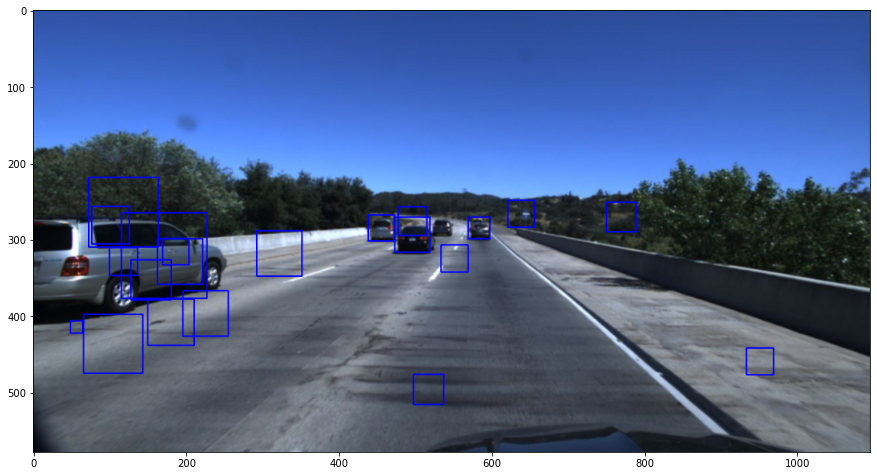

In [5]:
origin_cascade = cv2.CascadeClassifier('./cascade/cascade.xml')

frame = cv2.imread('testImage.png')

resize_frame = cv2.resize(frame, (np.int(frame.shape[1]*1.5), 
                                                         np.int(frame.shape[0]*1.5)))

gray_frame = cv2.cvtColor(resize_frame, cv2.COLOR_BGR2GRAY)
cars = origin_cascade.detectMultiScale(gray_frame, 1.3, 5)

for (x,y,w,h) in cars:
        cv2.rectangle(resize_frame,(x,y),(x+w,y+h),(255,0,0),2)

resize_frame = cv2.cvtColor(resize_frame, cv2.COLOR_BGR2RGB)
frame = cv2.resize(resize_frame, (np.int(resize_frame.shape[1]/1.5), 
                                                         np.int(resize_frame.shape[0]/1.5)))
plt.figure(figsize = (15,15))
plt.imshow(frame)
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

